# Analiza Tour de France 2023

Analizirali bomo statistiko kolesarske dirke po Franciji iz leta 2023. Podatki so bili zajeti iz strani [Pro Cycling Stats](https://www.procyclingstats.com/race/tour-de-france/2023) in obdelani s pomočjo pythona.

## Uvod

*Tour de France* ali *Dirka po Franciji* je vsakoletna kolesarska cestna dirka, ki obstaja že od leta 1903, traja 3 tedne in pelje kolesarje, kot je očitno iz imena, večinoma po Francoskih pokrajinah.

V zadnjih letih sodeluje med 20 in 22 ekip *(ang. teams)*, vsaka sestavljena iz 8 kolesarjev.

Razdeljena je v 21 posameznih etap *(ang. stages)*, katerih točne poti se vsako leto spremenijo, vendar vedno seštejejo v pribljižno 3500 km.

Vsaka etapa ima svojega zmagovalca, ki jo je prekolesrail v najmanjšem času, končni zmagovalec dirke pa je tisti, katerega skupni čas vseh etap je najmanjši. Zmagovalno ekipo se določi glede na čase najhitrejših treh članov ekipe v vsaki etapi.

Zdaj, ko vemo osnove, moramo podatke uvoziti. 

In [520]:
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

%matplotlib inline

kolesarji = pd.read_csv('csv_datoteke/kolesarji.csv', index_col='id')
etape = pd.read_csv('csv_datoteke/podatki_o_etapah.csv', index_col='št')
rezultati_etap = []
for e in range(21):
    rezultati_etap.append(pd.read_csv(f'csv_datoteke/etapa{e}.csv', index_col='id'))

pd.options.display.max_rows = 10

Najprej si oglejmo naše kolesarje in njihove podatke:

In [521]:
kolesarji

,ime,država,tip,ekipa,starost,teža,višina,ODR,GC,TT,Sprint,Climber
id,,,,,,,,,,,,
19,Adam Yates,gb,Climber,UAE Team Emirates,30,58.0,1.73,1902.0,5792.0,1018.0,130.0,7037.0
161,Simon Yates,gb,Climber,Team Jayco AlUla,30,58.0,1.72,765.0,4835.0,1133.0,218.0,6186.0
11,Tadej Pogacar,si,Climber,UAE Team Emirates,24,66.0,1.76,3781.0,5194.0,1821.0,226.0,7108.0
37,Thibaut Pinot,fr,Climber,Groupama - FDJ,33,63.0,1.80,1915.0,6903.0,1544.0,170.0,8798.0
151,Michael Woods,ca,Climber,Israel - Premier Tech,36,64.0,1.75,2752.0,2206.0,40.0,186.0,4978.0
...,...,...,...,...,...,...,...,...,...,...,...,...
76,Jordi Meeus,be,Classic,BORA - hansgrohe,25,80.0,1.90,1220.0,76.0,30.0,1131.0,382.0
192,Cees Bol,nl,Sprint,Astana Qazaqstan Team,27,83.0,1.94,574.0,525.0,306.0,1291.0,460.0
64,Phil Bauhaus,de,Sprint,Bahrain - Victorious,28,71.0,1.84,750.0,225.0,1.0,2383.0,836.0


Id je številka ki jo ima kolesar na dresu (kolesarji iz iste ekipe imajo številke z enakim številom desetic recimo 31-38). Teža kolesarja je podana v kg in višina v m. Tip kolesarja pa predstavlja v kateri kategoriji je kolesar najboljši. Imamo več kategorij, saj je relief etape vsak dan malo drugačen, na par etapah pa se tudi način merjenja časa popolnoma spremeni, več o tem kasneje, zaenkrat je le pomembno da vemo da kolesarji nabirajo točke v kategorijah ODR (one day races ali enodnevne dirke), GC (general classification ali skupna razvrstitev), TT (time trial ali kronometer), Sprint (šprint) in Climber (hribolazec).

Kategorija v kateri ima kolesar največ točk določi tip kolesarja. Tipi imajo enaka imena kot kategorije, z izjemo tipa Classic, ki pomeni kategorijo ODR.

Mogoče je na tej točki pametno razložiti TT ali kronometer, saj so ostale kategorije precej samoumevne, kronometer pa je mogoče za nepoznavalca kolesarstva novost. Kronometer se od ostalih kategorij razlikuje predvsem po tem, da kolesarji ne začnejo dirke naenkrat kot ponavadi, ampak individualno, eden za drugim, z razliko parih minut. To pomeni, da na kronometru za razliko od ostalih dirk, kjer se pogosto izoblikujejo velike skupine kolesarjev, ki nudijo dobro zaveterje, kolesar vozi sam proti vetru in zato težje razvije visoko hitrost.

Kolesarji v vsaki kategoriji pridobijo točke, ko so na dirki, ki vsebuje elemente te kategorije (gore ali hribi za kategorijo Climber, ravnine za Sprint), dovolj visoko uvrščeni.

Oglejmo si torej podatke o naših etapah, da ugotovimo katere od kategorij so prisotne na Tour de France:

In [522]:
etape

,avg speed,dolžina,strmost,točke terena,skupni vzpon,won how
št,,,,,,
1,41.550,182.0,3,166,3221,0.35 km solo
2,43.726,208.9,2,141,2949,0.95 km solo
3,40.989,193.5,2,68,2667,Sprint of large group
4,41.090,181.8,1,20,1427,Sprint of large group
5,41.170,162.7,4,239,3652,20.2 km solo
...,...,...,...,...,...,...
17,34.386,165.7,4,445,5399,13.1 km solo
18,44.951,184.9,1,18,1216,Sprint of small group
19,49.130,172.8,2,50,1934,Sprint of 3 riders


Vidimo torej povprečno hitrost zmagovalca (avg speed) podano v km/h, dolžino etape v km, strmost na lestvici 1-5, ki je določena glede na teren in je na spletni strani [Pro Cycling Stats](https://www.procyclingstats.com/race/tour-de-france/2023) označena z ikono, točke terena, prekolesarjeni skupni vzpon v m in won how ali način zmage.

Točke terena so izračunane malo bolj kompleksno, podrobno si lahko preberete [tukaj](https://www.procyclingstats.com/info/profile-score-explained), v glavnem pa gre za to kakšni so vzponi in kje se nahajajo: daljši, strmejši in bližje cilju so vredni največ točk.

Strmost je tudi tesno povezana s tem saj 1-5 pomeni:
1. ravnina
2. hribi z ravninskim ciljem
3. hribi z ciljem na klancu
4. gore z ravninskim ciljem
5. gore z ciljem na klancu

Na Tour de France kolesarji očitno ne nabirajo točk za ODR, saj je Tour de France 21-dnevna dirka, lahko pa nabirajo točke za ostale 4 kategorije, znotraj Tour de France pa so določene kategorije še posebaj izpostavljene in na koncu tudi zmagovalec v teh dobi nagrado, med dirko pa trenutni vodilni v določeni kategoriji nosi posebno majico. Tako ima najboljši na splošno rumeno majico, najboljši v šprintih zeleno, v vzpenanju belo z rdečimi pikami, najboljši med mladimi (pod 25) pa belo. V kategorije se bomo poglobili še kasneje.

Za zdaj si še oglejmo združene rezultate etap, vsi časi so podani v urah:

In [523]:
rezultati = reduce(lambda left,right: pd.merge(left, right, on = ['id'], how='outer'), rezultati_etap)
rezultati["skupni_čas"] = rezultati.sum(axis='columns', min_count=21)

In [524]:
rezultati.sort_values('skupni_čas')

,čas1,čas2,čas3,čas4,čas5,čas6,čas7,čas8,čas9,čas10,...,čas13,čas14,čas15,čas16,čas17,čas18,čas19,čas20,čas21,skupni_čas
id,,,,,,,,,,,,,,,,,,,,,
1,4.384,4.777,4.721,4.424,3.961,3.914,3.774,4.207,4.469,3.924,...,3.307,3.981,4.780,0.540,4.850,4.113,3.746,3.455,2.937,82.217
11,4.384,4.777,4.721,4.424,3.979,3.910,3.774,4.207,4.467,3.924,...,3.306,3.981,4.780,0.571,4.946,4.113,3.746,3.460,2.937,82.360
19,4.380,4.777,4.721,4.424,3.979,3.961,3.774,4.207,4.485,3.924,...,3.314,3.982,4.786,0.597,4.881,4.113,3.746,3.457,2.937,82.398
161,4.381,4.777,4.721,4.424,3.979,3.952,3.774,4.220,4.481,3.924,...,3.313,4.035,4.818,0.593,4.828,4.113,3.746,3.455,2.937,82.424
27,4.384,4.777,4.721,4.424,3.979,3.952,3.774,4.207,4.483,3.924,...,3.315,3.980,4.791,0.603,4.901,4.113,3.746,3.469,2.937,82.433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,4.637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,4.728,5.112,4.721,4.424,4.407,4.442,3.774,4.234,4.810,4.302,...,3.713,4.604,5.266,0.723,NaN,NaN,NaN,NaN,NaN,NaN
191,4.736,5.112,4.721,4.424,4.516,4.511,3.774,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Osnovne povezave med podatki

V tabeli etape opazimo, da se zdijo strmost, točke terena in skupni vzpon sorazmerni, kar bi bilo logično, saj vsi rastejo z razgibanostjo terena. Pa še preverimo če to res drži:

<Axes: xlabel='strmost', ylabel='skupni vzpon'>

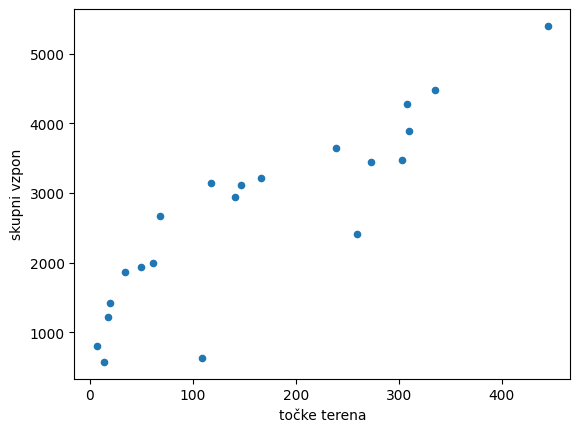

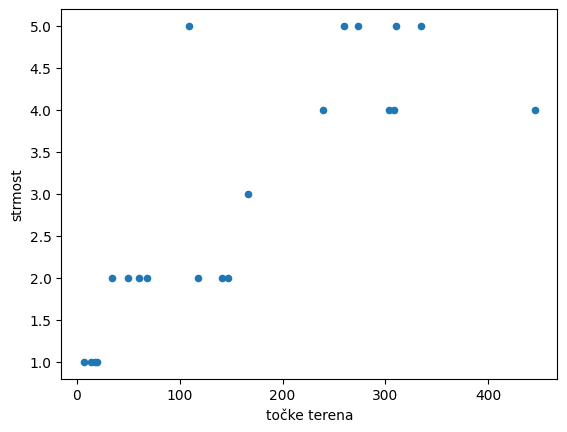

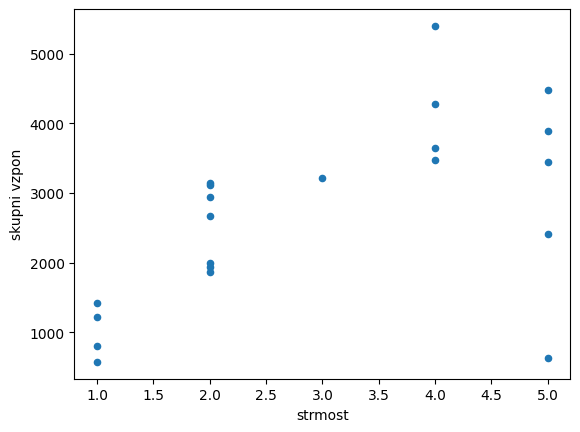

In [525]:
etape.plot.scatter(x='točke terena', y='skupni vzpon')
etape.plot.scatter(x='točke terena', y='strmost')
etape.plot.scatter(x='strmost', y='skupni vzpon')

Res izgleda da so vse tri sorazmerne, najlepše pa se to vidi na grafu med skupnim vzponom in točkami terena. Torej lahko v prihodnje uprabljamo le eno od njih.

Ponavadi se v hrib kolesari precej počasneje kot po ravnini, torej pričakujemo, da bo to razvidno v razmerju med povprečno hitrostjo zmagovalca in skupnim vzponom:

<Axes: xlabel='skupni vzpon', ylabel='avg speed'>

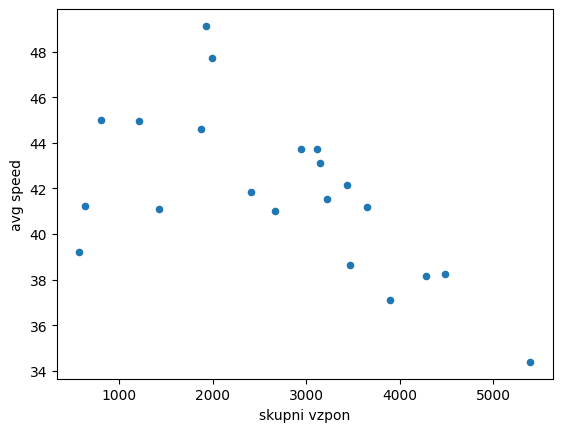

In [526]:
etape.plot.scatter(x='skupni vzpon', y='avg speed')

Res vidimo, da več kot je skupnega vzpona, manjša je povprečna hitrost. Malo izstopa pa ena točka na grafu levo spodaj, to je 21. etapa oziroma zadnji dan dirke. Glede na to, da je zadnji dan so kolesarji bolj utrujeni, obstaja pa še en razlog za odstopanje. Od leta 1975 naprej se 21. etapa odvija v Parizu in konča na Champs-Elysees. Profil Pariza je precej raven in kolesarjem ne dopušča veliko možnosti za napad *rumene majice*. Tako je po prvih parih letih brez napadov, zadnja etapa tradicionalno postala etapa na kateri kolesarji praznujejo konec dirke in uživajo s svojimi navijači ter se po nenapisanem dogovoru ne napadajo in posledično je njihova hitrost malo počasnejša.

## Tipi kolesarjev in tipi etap

Na Tour de France je 21 etap, ki so si med seboj različne po tipu in na katerih pričakujemo, da se bodo kolesarji tistega tipa odrezali bolje.

Najprej si oglejmo koliko predstavnikov vsakega tipa imamo:

<Axes: xlabel='tip'>

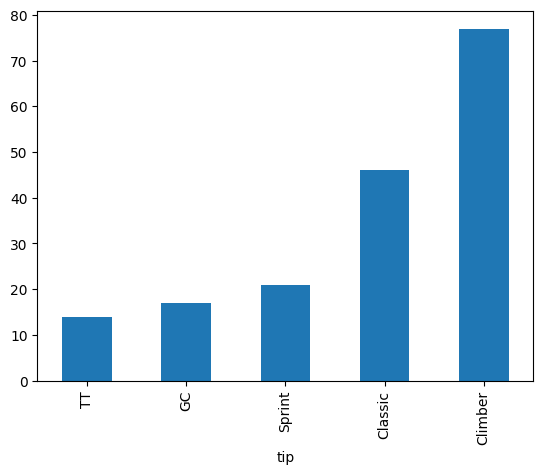

In [527]:
kolesarji.groupby('tip').size().sort_values().plot.bar()

Hribolazcev je daleč največ, sledijo klasiki, najmanj je kronometristov.

Glede na to, da je Tour de France sestavljena iz zelo profilno raznovrstnih etap bi pričakovali, da se bodo najbolje odrezali kolesarji tipa GC. Pa si poglejmo ali to drži in na splošno kateri tip kolesarja ima najboljši skupni čas na Tour de France:

<Axes: xlabel='tip'>

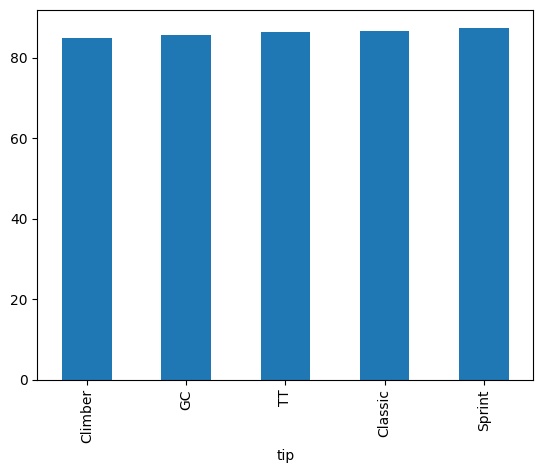

In [528]:
rezultati_kolesarji = pd.merge(kolesarji, rezultati, left_on='id', right_on='id')
rezultati_kolesarji.groupby('tip')['skupni_čas'].mean().sort_values().plot.bar()

Najkrajši povprečni čas imajo hribolazci, najdaljši pa šprinterji, kar nam nakazuje da je bila Tour de France 2023 bolj hribovska. Drugi Najboljše so se odrezali GC kar smo pričakovali, drugi najslabši so bili klasiki, kar je tudi razumljivo saj so specialisti za enodnevne dirke, kar pa Tour de France zagotovo ni.

Oglejmo si zdaj pozamezne etape. Leta 2023 je bila le ena kronometerska etapa, 4 izrazito ravninske (strmost 1) in 5 izrazito gorskih (strmost 5). Ker je bila kronometerska izrazito gorska in jo bomo obravnavali posebaj, jo ne bomo vključili v obravnavo izrazito gorskih.

Začnimo torej z kronometersko (16.) etapo:

<Axes: xlabel='tip'>

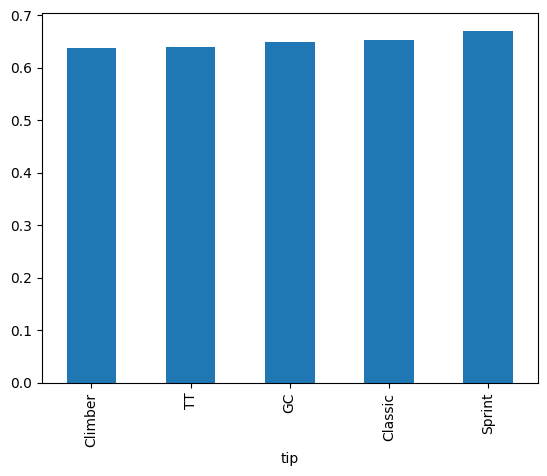

In [529]:
kronometer_tip = rezultati_kolesarji[['tip', 'čas16', 'TT']].dropna()
kronometer_tip.groupby('tip')['čas16'].mean().sort_values().plot.bar()

Na splošno so se na tej etapi odrezali najboljše hribolazci in prehiteli kronometriste, kar razumljivo glede na to da vemo, da je bila etapa izredno gorska. Najpočasnejši so bili šprinterji.

Vseeno si še oglejmo povezavo med rezultati posameznih kolesarjev in njihovimi točkami v kategoriji TT.

<Axes: xlabel='TT', ylabel='čas16'>

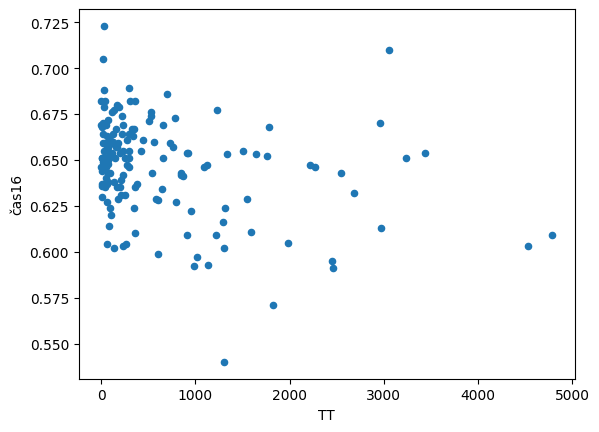

In [530]:
kronometer_tip.plot.scatter(x='TT', y='čas16')

Graf se do neke mere sklada z našo domnevo, opazimo pa, da veliko kolesarjev nima veliko točk v kategoriji TT, kar je lahko posledica njihove starosti, predvsem zmagovalec te etape preseneča, saj nima veliko TT točk.

Naslednje si bomo ogledali ravninske etape:

In [531]:
etape[etape.strmost == 1]


,avg speed,dolžina,strmost,točke terena,skupni vzpon,won how
št,,,,,,
4,41.090,181.8,1,20,1427,Sprint of large group
7,45.013,169.9,1,7,808,Sprint of large group
18,44.951,184.9,1,18,1216,Sprint of small group
21,39.190,115.1,1,14,577,Sprint of large group


<Axes: xlabel='tip'>

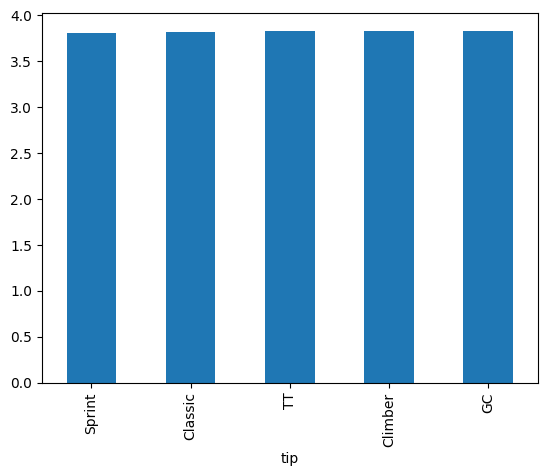

In [532]:
pd.options.mode.chained_assignment = None
šprint_tip = rezultati_kolesarji[['tip', 'Sprint', 'čas4', 'čas7', 'čas18', 'čas21']].dropna()
šprint_tip['povprečje_šprintov'] = šprint_tip.loc[:, 'čas4':'čas21'].mean(axis=1)
šprint_tip.groupby('tip')['povprečje_šprintov'].mean().sort_values().plot.bar()

Razlike tokrat res niso velike, vseeno pa so najhitrejši šprinterji, najpočasnejši pa kolesatrji tipa GC.

Spet si oglejmo še kako je s točkami v kategoriji Sprint in časi:

<Axes: xlabel='Sprint', ylabel='povprečje_šprintov'>

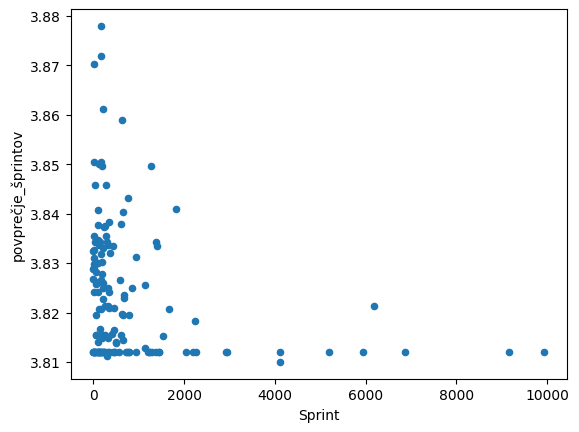

In [533]:
šprint_tip.plot.scatter(x='Sprint', y='povprečje_šprintov')

Tisti z veliko Sprint točkami imajo najboljše čase, zanimivo pa je da jih je veliko z malo Sprint točkami, ki imajo enako dobre čase. To bi spet lahko bila posledica mladih kolesarjev, ki nimajo nikjer še veliko točk.

Oglejmo si zdaj še gorske etape:

In [534]:
etape[etape.strmost == 5]

,avg speed,dolžina,strmost,točke terena,skupni vzpon,won how
št,,,,,,
6,37.083,144.9,5,310,3894,2.7 km solo
9,42.144,182.4,5,273,3441,0.44 km solo
13,41.853,137.8,5,260,2413,11.7 km solo
15,38.255,179.0,5,335,4483,10.8 km solo
16,41.227,22.4,5,109,636,"<a href=""race/tour-de-france/2023/stage-16/..."


<Axes: xlabel='tip'>

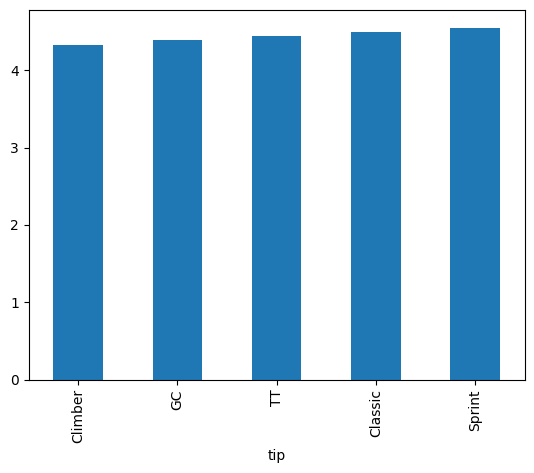

In [535]:
gore_tip = rezultati_kolesarji[['tip', 'Climber', 'čas6', 'čas9', 'čas13', 'čas15']].dropna()
gore_tip['povprečje_gor'] = gore_tip.loc[:, 'čas6':'čas15'].mean(axis=1)
gore_tip.groupby('tip')['povprečje_gor'].mean().sort_values().plot.bar()

Na gorskih etapah so imeli najboljše čase hribolazci, kot predvideno, najslaše je šlo šprinterjem. Razlike so bolj vidne kot pri ravninskih etapah, drugače pa je vrstni red tipov za ravninske etape skoraj ravno obraten temu.

Oglejmo si še točke iz kategorije Climber:

<Axes: xlabel='Climber', ylabel='povprečje_gor'>

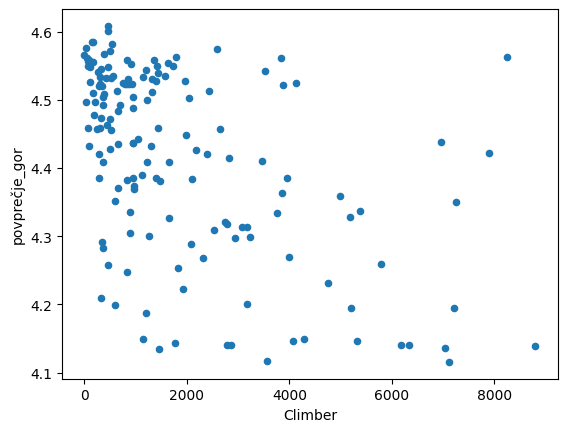

In [536]:
gore_tip.plot.scatter(x='Climber', y='povprečje_gor')

Tukaj je vzorec manj jasen, imamo veliko kolesarjev z malo točkami in slabšim časom, ampak tudi par kolesarjev z veliko točkami ima slabši čas, kolesarji z dobrimi časi pa imajo zelo raznovrstno število točk (1000-9000).

## Fizične značilnosti kolesarjev

Zanima nas ali obstaja povezava med fizičnimi značilnostimi kolesarja in njegovim končnim rezultatom.

Najprej si oglejmo razmerje med skupnim časom in starostjo kolesarjev:

<Axes: xlabel='starost'>

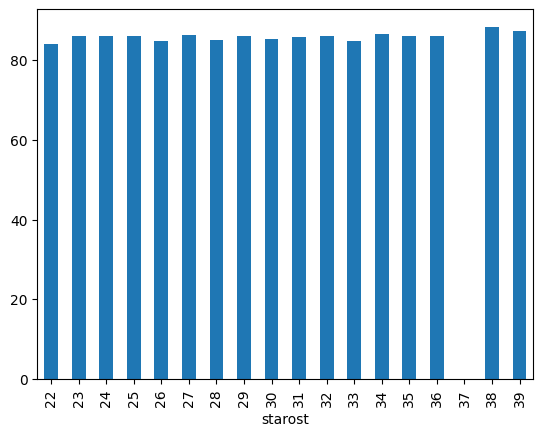

In [537]:
rezultati_kolesarji.groupby('starost')['skupni_čas'].mean().plot.bar()

Izgleda da starost ne vpliva na rezultate, vidimo pa, da noben od kolesarjev, ki so končali, ni star 37, zato bi bilo zanimivo pogledati koliko predstavnikov vsake starosti imamo.

<Axes: xlabel='starost'>

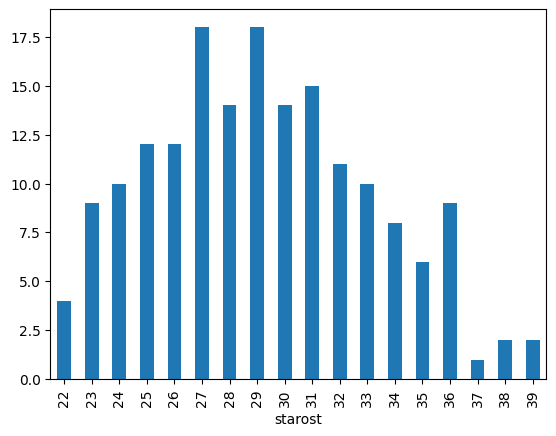

In [538]:
rezultati_kolesarji.groupby('starost').size().plot.bar()

Vidimo, da je največ kolesarjev starih med 27 in 31 let, starejših od 36 je le 5, in zdaj tudi vemo, da en 37-letnik je kolesaril, vendar pa dirke očitno ne dokončal.

Zdaj si oglejmo povezavo med višino in težo kolesarjev ter skupnim časom:

<Axes: xlabel='višina'>

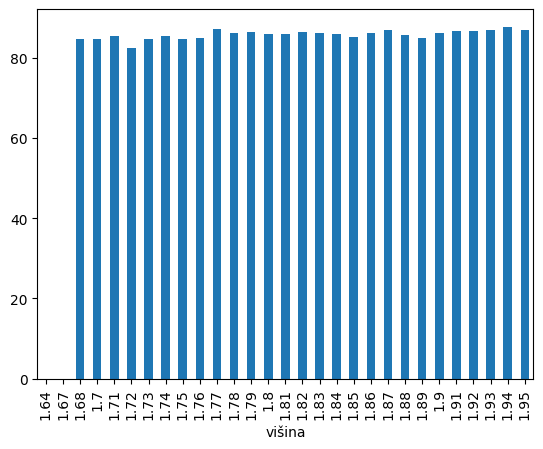

In [539]:
rezultati_kolesarji.groupby('višina')['skupni_čas'].mean().plot.bar()

<Axes: xlabel='teža'>

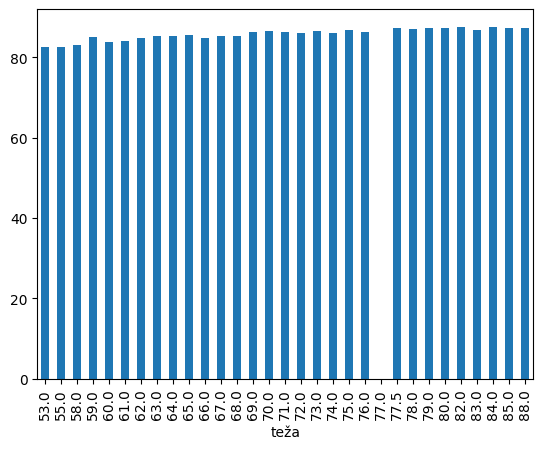

In [540]:
rezultati_kolesarji.groupby('teža')['skupni_čas'].mean().plot.bar()


Opazimo, da imajo manjši in lažji kolesarji v povprečju manjši skupni čas.

Kaj pa povezava med tipom kolesarja in njegovimi fizičnimi značilnostimi:

<Axes: xlabel='starost'>

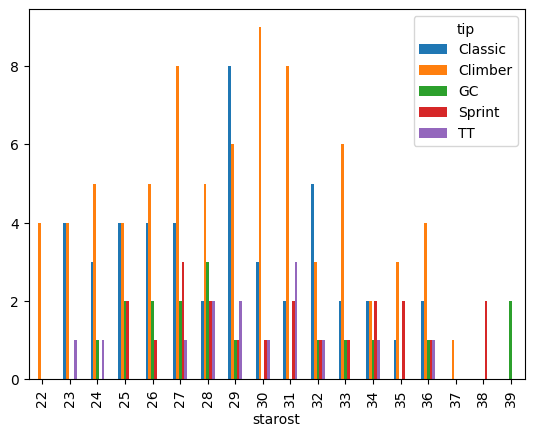

In [541]:
rezultati_kolesarji.groupby('starost').tip.value_counts().unstack().plot.bar()

Mlajši kolesarji so bolj pogosto hribolazci ali klasiki. Šprinterji se pojavijo šele pri straosti 25.

<Axes: xlabel='višina'>

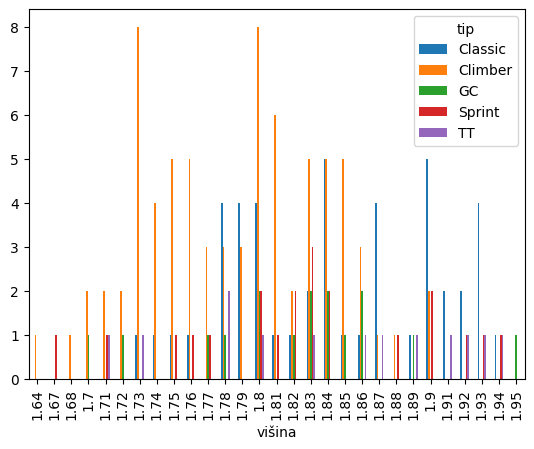

In [542]:
rezultati_kolesarji.groupby('višina').tip.value_counts().unstack().plot.bar()

<Axes: xlabel='teža'>

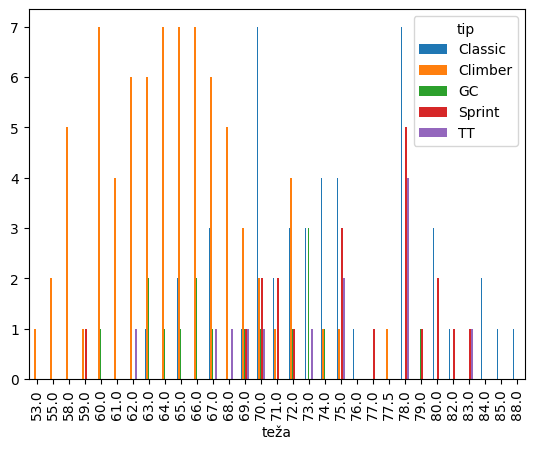

In [543]:
rezultati_kolesarji.groupby('teža').tip.value_counts().unstack().plot.bar()

Po višini in teži najbolj izstopajo hribolazci, izgleda da so najmanjši in predvsem najlažji, to je pričakovano, saj je večjo maso lažje peljati po ravnini kot v hrib. Po višini so si vsi ostali precej blizu, malo izstopajo klasiki, vendar pa jih je tudi več kot ostalih. Najtežji pa so šprinterji in klasiki, sledijo kronometristi.

## Ekipe

V letu 2023 je na Tour de France sodelovalo 22 ekip. Kot že prej omenjeno se najboljšo ekipo določi s seštevkom najboljših treh rezultatov na vsaki etapi.
Mi si bomo stvari ogledali malo drugače. Za začetek si oglejmo koliko članov vsake ekipe je sploh okončalo dirko:

<Axes: xlabel='ekipa'>

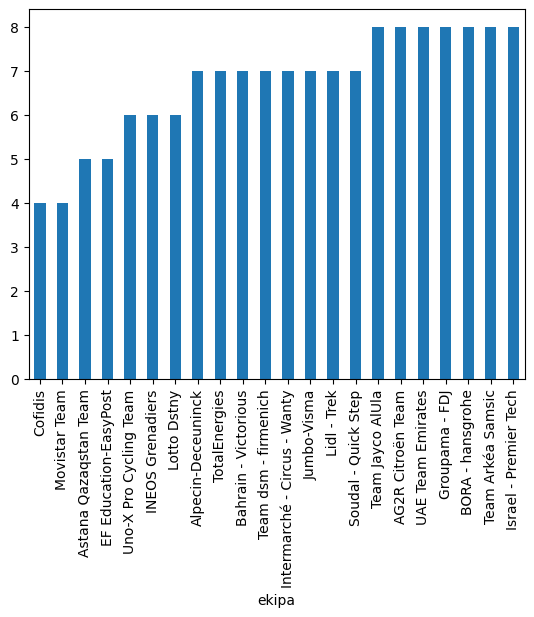

In [544]:
d = []
for e in range(21): d.append(f'čas{e+1}')
rezultati_ekipe = rezultati_kolesarji.dropna().drop(d, axis=1)
rezultati_ekipe.groupby('ekipa').size().sort_values().plot.bar()

Ker so nekatere ekipe izgubile tudi do 4 člane, jih bomo ocenili glede na povprečen skupni čas člana ekipe, ki je dokončal dirko:

<Axes: xlabel='ekipa'>

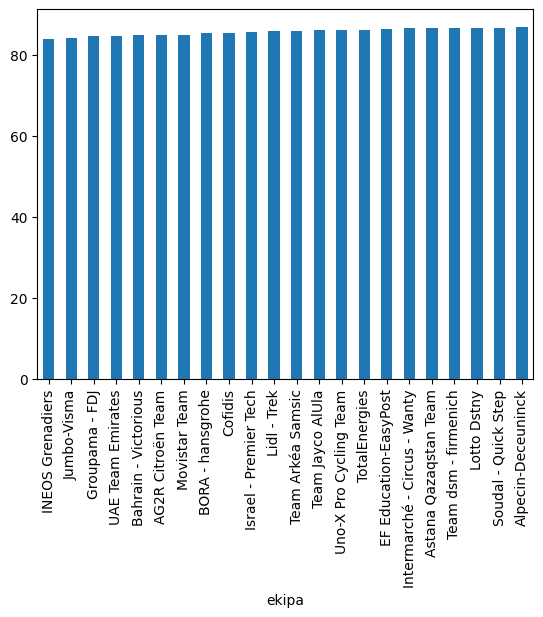

In [545]:
rezultati_ekipe.groupby('ekipa')['skupni_čas'].mean().sort_values().plot.bar()

Zdaj ko vemo katere ekipe imajo povprečno najboljše skupne čase si še oglejmo sestavo ekip glede na tip kolesarja:

<Axes: xlabel='ekipa'>

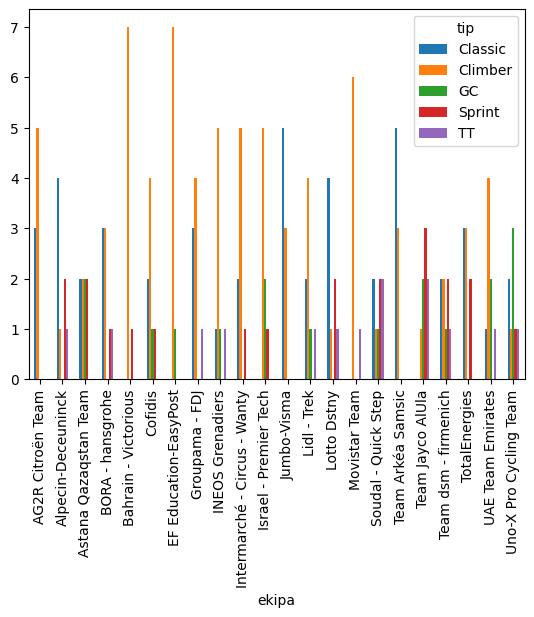

In [546]:
tipi_ekipe = kolesarji[['ekipa', 'tip']]
tipi_ekipe.groupby('ekipa').tip.value_counts().unstack().plot.bar()

Očitno je najpogodtejši tip kolesarja v ekipah na splošno hribolazec, kar je glede na to, da smo prej videli da imajo v povprečju hribolazci najboljši čas logično. Drugi najpogostejši je klasik. Najredkejši je kronometrist, kar je pričakovano, saj je večina etap na Tour de France nekronometerskih, leta 2023 je bila le ena.

Mogoče bi pričakovali več kolesarjev tipa GC, saj so za zmago na Tour de France potrebne vse veščine, vendar pa smo prej videli, da imajo najkrajši čas v povprečju še vseeno hribolazci.

Po raznovrstni sestavi ekipe izstopajo Astana Qazaqstan Team, Soudal - Quick Step, Uno-X Pro Cycling Team, Team Jayco AlUla in Team dsm - firmenich, ki pa glede na našo razvrstitev po časih niso v boljši polovici.

Prvih 5 ekip na naši razvrstitvi je sestavljenih pretežno iz hribolazcev in klasikov.

## Države

Države na Tour de France ne igrajo posebne vloge, ne zbira se točk po državah in na koncu se ne proglasi zmagovalne države ali česa podobnega. Vseeno pa bi bilo zanimivo pogledati ali obstaja povezava med rezultati in državami, mogoče se francozi odrežejo bolje, ker poznajo teren, mogoče so kolesarji iz držav z bolj gorskim terenom boljši v gorskih etapah. Najprej poglejmo koliko različnih držav je prisotnih na Tour de France 2023 in koliko ima vsaka predstavnikov:

In [547]:
kolesarji['država'].nunique()

27

<Axes: ylabel='država'>

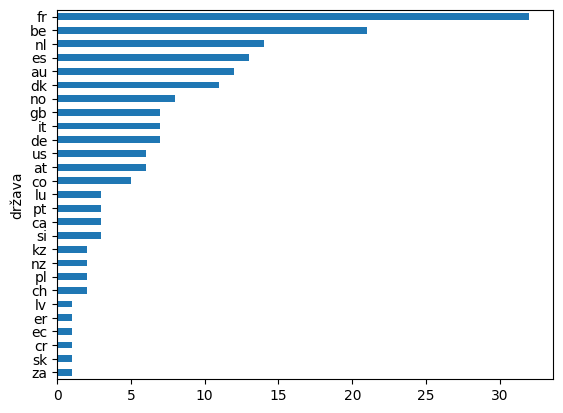

In [548]:
kolesarji.groupby('država').size().sort_values().plot.barh()

Največ je francozev, sledita belgija in nizozemska. Latvija, Eritreja, Ekvador, Costa Rica, Slovaška in Južna Afrika imajo le enega predstavnika.

Oglejmo si zdaj povprečni čas vsake države:

<Axes: ylabel='država'>

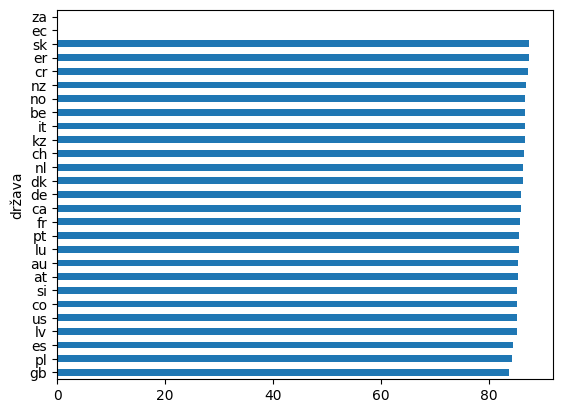

In [549]:
rezultati_kolesarji.groupby('država')['skupni_čas'].mean().sort_values().plot.barh()

Kolesarja iz Južne Afrike in Ekvadorja dirke nista dokončala. Kolesarji iz Velike Britanije imajo najboljši povprečen čas, sledijo poljaki in estonci. Francozi so nekje na sredini.

Poglejmo si zdaj še tipe kolesarjev iz različnih držav:

<Axes: xlabel='država'>

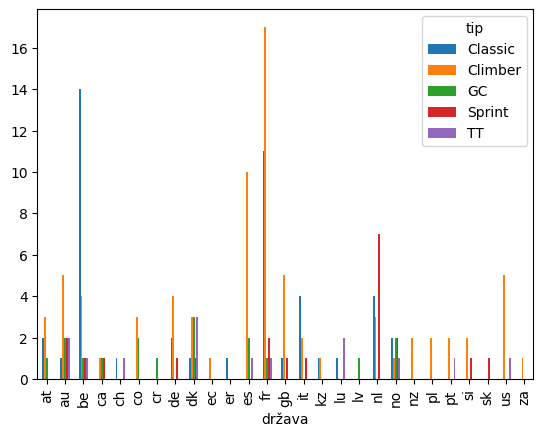

In [550]:
kolesarji.groupby('država').tip.value_counts().unstack().plot.bar()

Večina držav ima največ hribolazcev, kar je pričakovano saj jih je tudi na splošno največ. Po številu hribolazcev v primerjavi z ostalimi najbolj izstopajo Estonija, USA, Velika Britanija in Francija, čeprav ima zadnja samo občutno več kolesarjev na splošno. Belgija najbolj izstopa z ogromnim številom klasikov, podobno tudi Italija. Nizozemska ima veliko šprinterjev, kar je mogoče indikator povezanosti površja države s tipom kolesarja, saj ima nizozemska precej ravno površje.

## Zaključek

Ugotovili smo torej, da imajo v etapi določenega tipa najkrajši čas večinoma kolesarji tistega tipa. Hribolazci so povprečno malajši, manjši in predvsem lažji, šprinterji so starejši in težji. Največ je hribolazcev in imajo tudi najboljši povprečen čas, zato so tudi najpogostejši v ekipah. Največ tekmovalcev je iz Francije, nekatere države izstopajo po tipu kolesarjev, recimo Nizozemska, kateri glavni predstavniki so šprinterji.